This is a notebook to plot the aspect ratios of all pseduo_labels and its corresponding ground truths. 

In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
from prototype_utils import (
    filter_gt_labels_by_category,
    extract_face_corners,
    filter_cuboids_by_roi,
    filter_roi,
    bboxes_df_to_numpy_corners)
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
from av2.structures.cuboid import  CuboidList
from config import CONFIG

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
home = os.path.join(os.path.expanduser('~'))

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 1
frame_idx = 0

scene_id = av2.get_log_ids()[scene_idx]
print(f"scene_id: {scene_id}")
frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
print(f"frame_id: {frame_id}")
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)
print(f"frame_path: {frame_path}")

points = Sweep.from_feather(frame_path).xyz

INFO - 2025-01-17 14:12:07,127 - synchronization_database - Building SynchronizationDB


scene_id: 01bb304d-7bd8-35f8-bbef-7086b688e35e
frame_id: 315968867659956000
frame_path: /home/ravi.kumar/dataset/av2/train/01bb304d-7bd8-35f8-bbef-7086b688e35e/sensors/lidar/315968867659956000.feather


In [4]:
if CONFIG['ROI']:
    ps_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['ROI'])
else:
    ps_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['FULL_RANGE'])


In [5]:
ps_scene_path = os.path.join(ps_path, os.listdir(ps_path)[scene_idx])
ps_frame_path = os.path.join(ps_scene_path, os.listdir(ps_scene_path)[frame_idx])
ps_labels_df = pd.read_feather(ps_frame_path)
ps_labels_df.head()

,box_center_x,box_center_y,box_length,box_width,ry
0,9.790271,-18.375053,6.638255,6.279974,1.047198
1,9.953125,-11.792969,1.729097,1.209816,2.356194
2,5.057304,-15.102226,1.597996,0.621472,2.879793
3,1.227810,17.505859,5.980841,0.654646,1.047198
4,3.400963,-14.079392,0.347801,0.090486,0.174533


In [6]:
os.listdir(os.path.join(ps_path, os.listdir(ps_path)[0]))

['315967287360099000.feather',
 '315967272160341000.feather',
 '315967279560167000.feather',
 '315967284360226000.feather',
 '315967273460224000.feather',
 '315967283960119000.feather',
 '315967286360141000.feather',
 '315967287060173000.feather',
 '315967285459716000.feather',
 '315967281660278000.feather',
 '315967272360070000.feather',
 '315967287559828000.feather',
 '315967280059807000.feather',
 '315967280560125000.feather',
 '315967275060018000.feather',
 '315967274060060000.feather',
 '315967283859923000.feather',
 '315967273559757000.feather',
 '315967286959992000.feather',
 '315967281260156000.feather',
 '315967279059849000.feather',
 '315967280359732000.feather',
 '315967282859965000.feather',
 '315967283759727000.feather',
 '315967276860219000.feather',
 '315967278059891000.feather',
 '315967273860346000.feather',
 '315967276160171000.feather',
 '315967285360183000.feather',
 '315967276560293000.feather',
 '315967284760348000.feather',
 '315967273060102000.feather',
 '315967

In [7]:
# def get_pseudo_label_corners_scene(ps_scene_path: str) -> np.ndarray:
#     """
#     Processes all the pseudo-label files in the given scene path and returns a 
#     combined numpy array of shape (P, 4, 2), where P is the total number of bounding boxes.

#     Args:
#         ps_scene_path (str): Path to the scene folder containing pseudo-label files.

#     Returns:
#         np.ndarray: A numpy array of shape (P, 4, 2) representing all bounding box corners.
#     """
#     main_lst = []

#     for idx, frame in enumerate(os.listdir(ps_scene_path)):
#         ps_frame_path = os.path.join(ps_scene_path, frame)
#         ps_labels_df = pd.read_feather(ps_frame_path)

#         # Convert the DataFrame to numpy array of shape (Q, 4, 2)
#         corners_array = bboxes_df_to_numpy_corners(ps_labels_df)
#         main_lst.append(corners_array)

#     # Combine all arrays into one of shape (P, 4, 2)
#     combined_array = np.vstack(main_lst)
#     return combined_array

# def get_pseudo_label_corners_all(ps_base_path: str):
#     main_lst = []
    
#     for scene in os.listdir(ps_base_path):
#         ps_scene_path = os.path.join(ps_base_path, scene)
#         scene_corners = get_pseudo_label_corners_scene(ps_scene_path)
#         main_lst.append(scene_corners)
    
#     return np.vstack(main_lst)


def get_all_dataframes(ps_base_path: str):
    main_lst = []
    
    for scene in os.listdir(ps_base_path):
        ps_scene_path = os.path.join(ps_base_path, scene)
        
        for frame in os.listdir(ps_scene_path):
            ps_frame_path = os.path.join(ps_scene_path, frame)
            ps_labels_df = pd.read_feather(ps_frame_path)
            elem = {"scene_id": scene, "frame_id": frame, "data": ps_labels_df}
            main_lst.append(elem)
    
    return main_lst


from typing import List, Dict
def get_ps_aspect_ratios_and_areas(lst_of_dicts: List[Dict]):
    aspect_ratio_lst = []
    area_lst = []
    count = 1
    for idx, elem in enumerate(lst_of_dicts):
        scene_id, frame_id, df = elem["scene_id"], elem["frame_id"], elem["data"]
        df['area'] = df['box_length'] * df['box_width']
        df['aspect_ratio'] = df['box_width'] / df['box_length']
        
        # first_index_in_range = find_first_index_in_aspect_ratio_range(df, lower=0.2, upper=0.3)
        # if first_index_in_range is not None and count > 0:
        #     print(f"Scene: {scene_id}, Frame: {frame_id}, frame_idx:{idx}, bbox_idx in frame: {first_index_in_range}")
        #     count -= 1
        
        aspect_ratio_lst.extend(df['aspect_ratio'].tolist())
        area_lst.extend(df['area'].tolist())
        
    return aspect_ratio_lst, area_lst

# def find_first_index_in_aspect_ratio_range(df, lower=0.2, upper=0.3):
#     """
#     Find the first index of a row in the DataFrame where the aspect_ratio column is in the range [lower, upper].
    
#     Args:
#     - df (pd.DataFrame): DataFrame with an 'aspect_ratio' column.
#     - lower (float): Lower bound of the range (inclusive).
#     - upper (float): Upper bound of the range (inclusive).

#     Returns:
#     - int: The first index where the condition is satisfied, or None if no match is found.
#     """
#     condition = (df['aspect_ratio'] >= lower) & (df['aspect_ratio'] <= upper)
#     if condition.any():  # Check if there is any matching row
#         return condition.idxmax()  # Return the first index where the condition is True
#     return None  # Return None if no match is found

# def calc_aspect_ratio_and_area(gt_corners: np.ndarray):
#     lst_of_dicts = []
#     for idx, cuboid in enumerate(gt_corners):
#         side_1 = np.linalg.norm(cuboid[0] - cuboid[1])
#         side_2 = np.linalg.norm(cuboid[1] - cuboid[2])
#         side_3 = np.linalg.norm(cuboid[2] - cuboid[3])
#         side_4 = np.linalg.norm(cuboid[3] - cuboid[0])
        
#         length = max(side_1, side_2, side_3, side_4)
#         width = min(side_1, side_2, side_3, side_4)
#         aspect_ratio = width / length
#         if aspect_ratio > 0.2 and aspect_ratio < 0.3:
#             print(f"Aspect ratio: {aspect_ratio} at index {idx}")
#         area = length * width
#         lst_of_dicts.append({"corners": cuboid,"aspect_ratio": aspect_ratio, "area": area})

#     return lst_of_dicts

In [8]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def plot_kde2(aspect_ratios,x_label="Aspect Ratio", title="Aspect Ratios of GT Cuboids (KDE)"):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean, median, and standard deviation on the plot.
    
    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    median_value = np.median(aspect_ratios)
    std_dev = np.std(aspect_ratios)
    
    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)
    
    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.title(title)
    
    # Add statistics as text on the plot
    text_str = (f"Mean: {mean_value:.4f}\n"
                f"Median: {median_value:.4f}\n"
                f"Std Dev: {std_dev:.4f}")
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()
    
    
def plot_kde3(aspect_ratios, x_label="Aspect Ratio", title="Aspect Ratios of GT Cuboids (KDE)", xlim=(0, 10)):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean, median, and standard deviation on the plot.

    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    median_value = np.median(aspect_ratios)
    std_dev = np.std(aspect_ratios)
    minimum = np.min(aspect_ratios) 
    maximum = np.max(aspect_ratios)
    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)

    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.title(title)
    
    # Set x-axis limit to focus on the range 0-5
    plt.xlim(xlim)

    # Add statistics as text on the plot
    text_str = (f"Mean: {mean_value:.4f}\n"
                f"Median: {median_value:.4f}\n"
                f"Std Dev: {std_dev:.4f}\n"
                f"Minimum: {minimum:.4f}\n"
                f"Maximum: {maximum:.4f}")
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

In [9]:
lst_of_dicts = get_all_dataframes(ps_path)
aspect_ratios, areas  = get_ps_aspect_ratios_and_areas(lst_of_dicts)


# ps_corners_calculated = calc_aspect_ratio_and_area(ps_corners_all)
# ps_aspect_ratios = [cuboid["aspect_ratio"] for cuboid in ps_corners_calculated]
# ps_areas = [cuboid["area"] for cuboid in ps_corners_calculated]

In [10]:
# clean up  ps_aspect_ratios from any NaNs or infs
ps_aspect_ratios = np.array(aspect_ratios)
ps_aspect_ratios = ps_aspect_ratios[~np.isnan(ps_aspect_ratios)]
ps_aspect_ratios = ps_aspect_ratios[~np.isinf(ps_aspect_ratios)]
ps_aspect_ratios = ps_aspect_ratios.tolist()

In [11]:
# check whether it has NaNs or infs
print(type(ps_aspect_ratios))
print(np.isnan(ps_aspect_ratios).any())
print(np.isinf(ps_aspect_ratios).any())

<class 'list'>
False
False


In [14]:
ps_areas = areas
print(type(ps_areas))
print(np.isnan(ps_areas).any())
print(np.isinf(ps_areas).any())

<class 'list'>
False
False


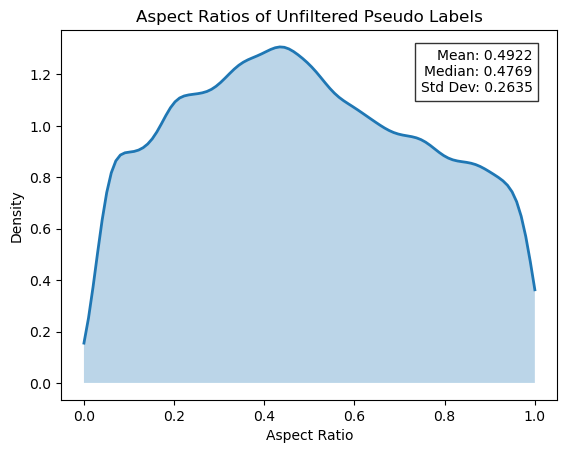

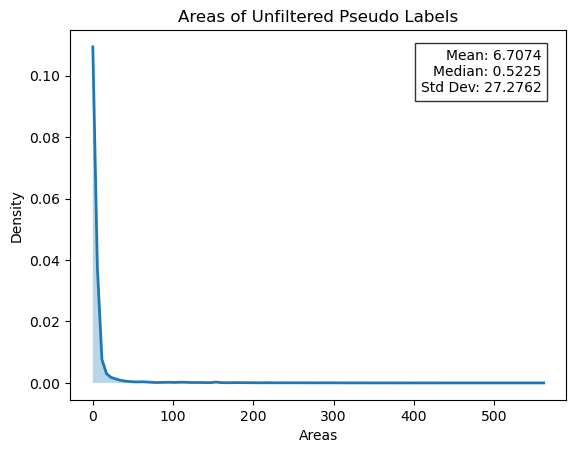

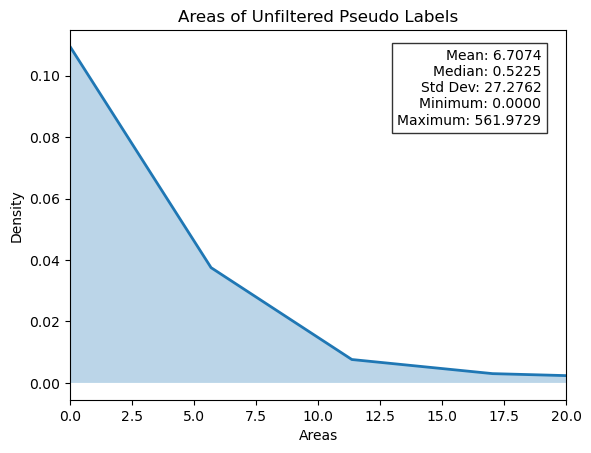

In [22]:
plot_kde2(ps_aspect_ratios, title="Aspect Ratios of Unfiltered Pseudo Labels")
plot_kde2(ps_areas,x_label="Areas", title="Areas of Unfiltered Pseudo Labels")
plot_kde3(ps_areas,x_label="Areas", title="Areas of Unfiltered Pseudo Labels", xlim=(0, 20))

In [17]:
print(len(areas))
print(len(aspect_ratios))

90015
90015


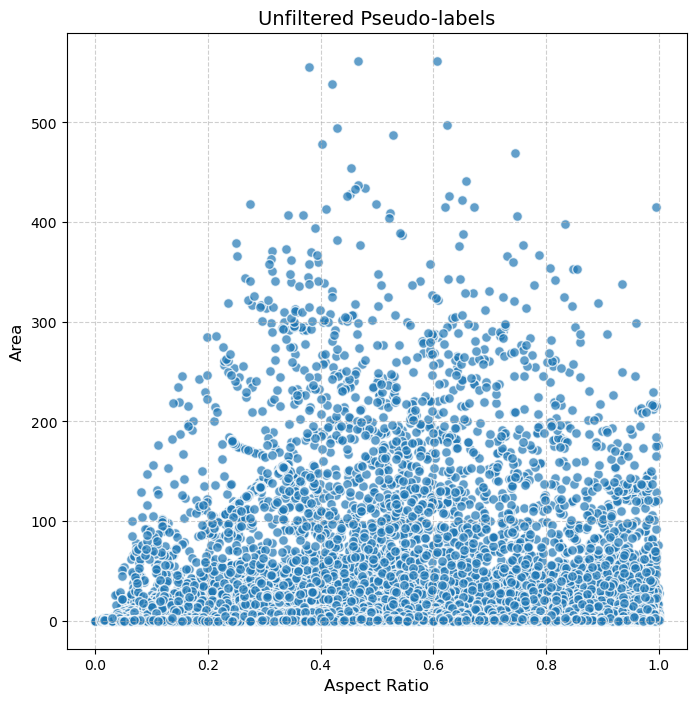

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_area_vs_aspect_ratio(aspect_ratio, area):
    """
    Plots a scatter plot of Area vs Aspect Ratio.

    Parameters:
        aspect_ratio (list or numpy.ndarray): List or array of aspect ratio values.
        area (list or numpy.ndarray): List or array of area values.
    """
    if not isinstance(aspect_ratio, (list, np.ndarray)) or not isinstance(area, (list, np.ndarray)):
        raise ValueError("Both aspect_ratio and area must be lists or numpy arrays.")

    if len(aspect_ratio) != len(area):
        raise ValueError("aspect_ratio and area must have the same length.")

    plt.figure(figsize=(8, 8))
    plt.scatter(aspect_ratio, area, alpha=0.7, edgecolors='w', s=50)

    plt.title("Unfiltered Pseudo-labels", fontsize=14)
    plt.xlabel("Aspect Ratio", fontsize=12)
    plt.ylabel("Area", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_area_vs_aspect_ratio(aspect_ratios, areas)